In [1]:
import importlib
import os
import fnmatch
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import csv
from sklearn import tree
import sys
sys.stdout.flush()
import math
import matplotlib.pyplot as plt
from matplotlib.table import Table
import segment_cluster as sc
import importlib
importlib.reload(sc)
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

np.random.seed(0)

cwd = os.getcwd()
if cwd.split("/")[1] == "home":
    data_path="/home/jkok1g14/Documents/GRS1915+105/data/Std1_PCU2"
elif cwd.split("/")[1] == "export":
    data_path="/export/data/jakubok/GRS1915+105/Std1_PCU2"
else:
    print("Set the path of data directory!", Flush=True)

#creates a dictionary of observation_ID: "state" items for labeled observations
clean_belloni = open('1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

#creates a list of labeled observations with abailable data
available = []
pool=[]
#/home/jkok1g14/Documents/GRS1915+105/data
#/export/data/jakubok/GRS1915+105/Std1_PCU2
for root, dirnames, filenames in os.walk(data_path):
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        available.append(filename)
for ob, state in ob_state.items():
    if ob+"_std1_lc.txt" in available:
        pool.append(ob)  

#create a list of arrays with time and counts for the set of Belloni classified observations
lc_dirs=[]
lcs=[]
ids=[]
for root, dirnames, filenames in os.walk(data_path):    
    for filename in fnmatch.filter(filenames, "*_std1_lc.txt"):
        if filename.split("_")[0] in pool:
            lc_dirs.append(os.path.join(root, filename))

            
#make 2D arrays for light curves, with columns of counts and time values
for lc in lc_dirs:
    ids.append(lc.split("/")[-1].split("_")[0])
    f=np.loadtxt(lc)
    f=np.transpose(f)#,axis=1)
    f=f[0:2]
    ###1s average and time check to eliminate points outside of GTIs
    f8t = np.mean(f[0][:(len(f[0])//8)*8].reshape(-1, 8), axis=1)
    f8c = np.mean(f[1][:(len(f[1])//8)*8].reshape(-1, 8), axis=1)
    #f8c=f8c-np.mean(f8c)#normalisation/mean centering/whatever you desire most
    rm_points = []
    skip=False
    for i in range(len(f8t)-1):
        if skip==True:
            skip=False
            continue
        delta = f8t[i+1]-f8t[i]
        if delta > 1.0:
            rm_points.append(i+1)
            skip=True   
    times=np.delete(f8t,rm_points)
    counts=np.delete(f8c,rm_points)
    lcs.append(np.stack((times,counts)))
#a list of light curve 2D arrays

lc_classes=[]
for i in ids:
    lc_classes.append(ob_state[i])

drop_classes=[]
for clas, no in Counter(lc_classes).items():
    if no<7:
        drop_classes.append(clas)

lcs_abu = []
classes_abu = []
ids_abu = []
for n, lc in enumerate(lc_classes):
    if lc not in drop_classes:
        classes_abu.append(lc)
        lcs_abu.append(lcs[n])
        ids_abu.append(ids[n])  
#a list of light curve 2D arrays of classes with at least 7 light curves
x_train, x_test, y_train, y_test, id_train, id_test = train_test_split(lcs_abu, classes_abu, ids_abu, test_size=0.25, stratify=classes_abu)

model_class="rho"
#find the class to be modelled only, the rho class
rho_index_train=np.where(np.array(y_train)==model_class)[0]


In [105]:
#### for y scaling
from sklearn.cluster import KMeans
all_train_segments=[]
for ts_index_index in rho_index_train:
    ts=x_train[ts_index_index]
    train_segments=sc.segmentation(ts, 100, 1, time_stamps=True)
    all_train_segments.append(train_segments)
all_train_segments=np.vstack(all_train_segments)
cluster=KMeans(n_clusters=8, random_state=0)
cluster.fit(all_train_segments[:,1,:])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [24]:
from sklearn.cluster import DBSCAN
##train the model
#loop throught the light curves of a given class and segments them
all_train_segments=[]
for ts_index_index in rho_index_train:
    ts=x_train[ts_index_index]
    train_segments=sc.segmentation(ts, 50, 1, time_stamps=True)
    all_train_segments.append(train_segments)
all_train_segments=np.vstack(all_train_segments)
#cluster the segments
cluster=DBSCAN(eps=3, min_samples=10)
#cluster.fit(all_train_segments[:,1,:])
clusters=cluster.fit_predict(all_train_segments[:,1,:])

In [98]:
cluster=DBSCAN(eps=1000, min_samples=3)
#cluster.fit(all_train_segments[:,1,:])
clusters=cluster.fit_predict(all_train_segments[:,1,:])

In [99]:
from sklearn.decomposition import PCA
pca= PCA()
pca.fit(all_train_segments[:,1,:])
# print(pca.explained_variance_ratio_)
# plt.plot(pca.explained_variance_ratio_)
# print(sum(pca.explained_variance_ratio_[:10]))
trans_data = pca.transform(all_train_segments[:,1,:]) 


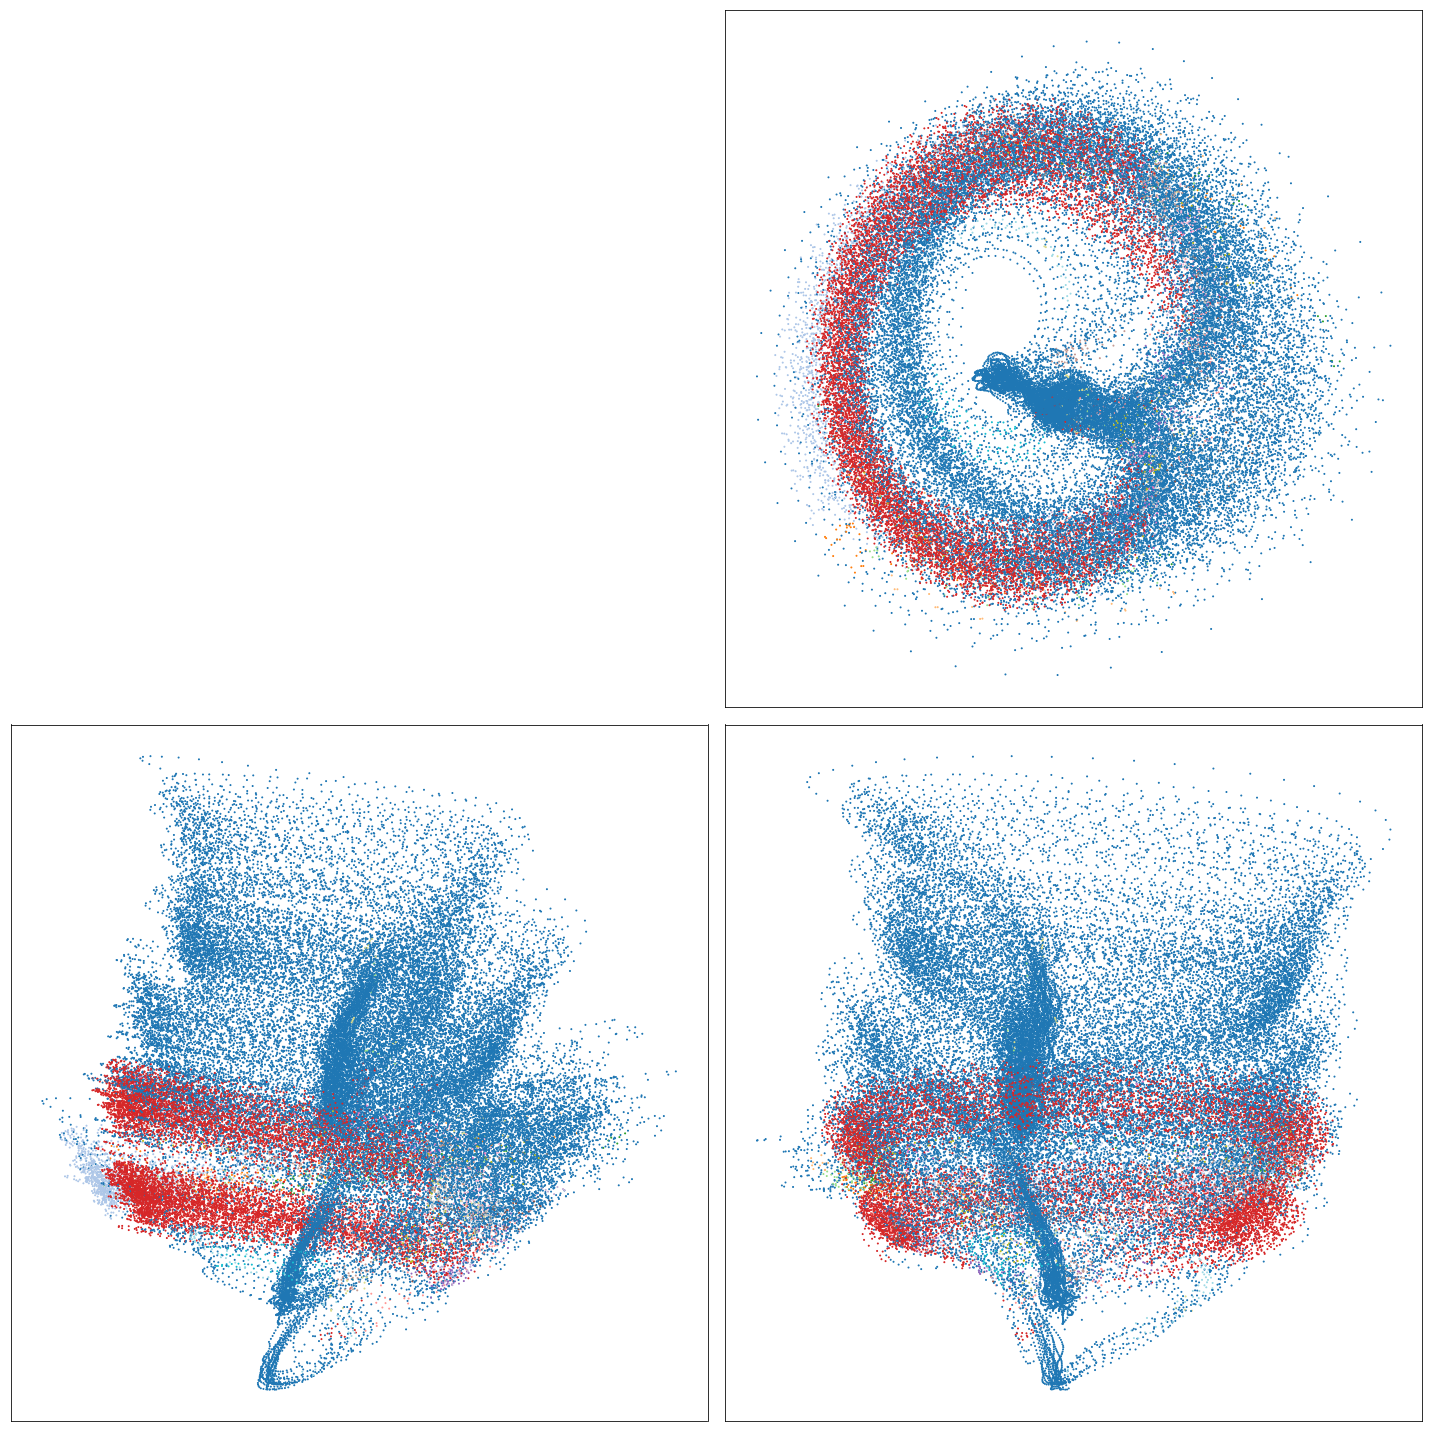

In [100]:
%matplotlib inline
plt.figure(figsize=(20,20))
plt.subplot(222)
plt.scatter(trans_data[:,0],trans_data[:,1],s=1, c=clusters, cmap="tab20")
plt.setp(plt.gca(), xticks=[], yticks=[])
plt.subplot(223)
plt.scatter(trans_data[:,0],trans_data[:,2],s=1, c=clusters, cmap="tab20")
plt.setp(plt.gca(), xticks=[], yticks=[])
plt.subplot(224)
plt.scatter(trans_data[:,1],trans_data[:,2],s=1, c=clusters, cmap="tab20")
plt.setp(plt.gca(), xticks=[], yticks=[])
plt.tight_layout()
#plt.suptitle("combinations of the first three principal components of rho training light curves, color code for k-means clusters (k=10)")
#plt.savefig("christmas_tree.png", dpi=300)
plt.show()

In [108]:
pred_centroid

5

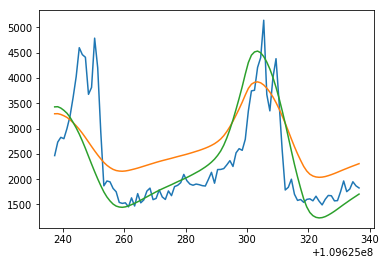

In [114]:
plt.plot(all_train_segments[10][0],all_train_segments[10][1])
std_ori=np.std(all_train_segments[10][1])
mean_ori=np.mean(all_train_segments[10][1])


pred_centroid=cluster.cluster_centers_[cluster.predict(all_train_segments[10][1].reshape(1, -1))[0]]
std_pred=np.std(pred_centroid)
mean_pred=np.mean(pred_centroid)
pred_centroid2=mean_ori+(pred_centroid-mean_pred)*(std_ori/std_pred)

plt.plot(all_train_segments[10][0], pred_centroid)
plt.plot(all_train_segments[10][0], pred_centroid2)

In [ ]:

#lists for the validation results 
#numbers of clusters and segment lengths to be tested
reco_error=[]
#reco_classes=[]
k_clusters=[5, 25, 50]
seg_lens=[8, 60, 100]
for k_id, k_cluster in enumerate(k_clusters):
    for len_id, seg_len in enumerate(seg_lens):
        # calculate the slide values
        seg_slides=[1, int(seg_len*0.25), int(seg_len*0.5)]
        for slide_id, seg_slide in enumerate(seg_slides):
            #leave one out cross validation
            loo_ID=0
            for train_index, valid_index in loo.split(rho_index_train):
                ##train the model
                #loop throught the light curves of a given class and segments them
                all_train_segments=[]
                for ts_index_index in train_index:
                    ts=x_train[rho_index_train[ts_index_index]]
                    train_segments=sc.segmentation(ts, seg_len, seg_slide, time_stamps=True)
                    all_train_segments.append(train_segments)
                all_train_segments=np.vstack(all_train_segments)
                #cluster the segments
                cluster=KMeans(n_clusters=k_cluster, random_state=0)
                cluster.fit(all_train_segments[:,1,:])
                
                ### reconstruction: complete for every validation observation in leave-one-out. Then do once for lcs of all other classes
                loo_valid_ts=x_train[rho_index_train[valid_index][0]]
                loo_valid_ts_id=id_train[rho_index_train[valid_index][0]]
                valid_segments= sc.segmentation(loo_valid_ts, seg_len, int(seg_len/2) , time_stamps=True)
                reco = sc.reconstruct(valid_segments, loo_valid_ts, cluster, rel_offset=False)
                error=np.sqrt(np.mean((loo_valid_ts[1][seg_len:-seg_len]-reco[1][seg_len:-seg_len])**2))
                reco_error.append((k_id,len_id,slide_id,loo_ID,int(loo_valid_ts_id.replace("-","")), error))
                print((k_id,len_id,slide_id,loo_ID,int(loo_valid_ts_id.replace("-","")), error))
                loo_ID+=1
            #reconstruction loop through light curves for every class other than rho              
            classes=list(set(y_train))
            for n_valid, valid_class in enumerate(classes):
                if valid_class == model_class:
                    continue
                validation_ids=np.where(np.array(y_train)=='{}'.format(valid_class))[0]
                for ts_id in validation_ids:
                    valid_ts=x_train[ts_id]
                    valid_segments= sc.segmentation(valid_ts, seg_len, int(seg_len/2) , time_stamps=True)
                    reco = sc.reconstruct(valid_segments, valid_ts, cluster, rel_offset=False)
                    error=np.sqrt(np.mean((valid_ts[1][seg_len:-seg_len]-reco[1][seg_len:-seg_len])**2))
                    reco_error.append((k_id,len_id,slide_id,n_valid,int(id_train[ts_id].replace("-","")), error))
                    print((k_id,len_id,slide_id,n_valid,int(id_train[ts_id].replace("-","")), error))
reco_error_ar=np.array(reco_error)